# Analysis of baseline mobility network

We analyse the properties of the directed, weighted baseline UK mobility network and we obtain multiscale flow communities with Markov Stability analysis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn import metrics
import seaborn as sns

import matplotlib.gridspec as gridspec
from math import log

import warnings
warnings.filterwarnings("ignore")


In [2]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import remove_self_loops, visualse_largest_components
from utils import R2_score

root_figure = path+"/figures/"
root_map = path+'/data/geo_shapefiles//NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
root_networks = path+"/data/processed/networks/"
root_results = path+"/results/"

In [3]:
plt.rcParams.update({'font.size': 20})

## Import LSCC 

In [4]:
# load baseline network
A_LSCC = sp.load_npz(root_networks+"baseline_network.npz")
lscc = nx.from_scipy_sparse_matrix(A_LSCC,create_using = nx.DiGraph)

# load node quadkeys
lscc_nodes = []
with open(root_networks+'node_quadkeys.txt', 'r') as filehandle:
    for line in filehandle:
        curr_quadkey = line[:-1]
        lscc_nodes.append(curr_quadkey)
n_nodes = len(lscc_nodes)

# Store node numbers
node_numbers = {i : lscc_nodes[i] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
A_LSCC_array = A_LSCC.toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

# Subtract self-loops
B_LSCC_array = A_LSCC - np.diag(np.diag(A_LSCC.toarray()))
B_LSCC = sp.csr_matrix(B_LSCC_array)

## Dynamical properties of LSCC and detailed balance

In [5]:
# Compute stationary distribution
graph = B_LSCC
dinv = np.asarray(np.divide(1,graph.sum(axis=1),where=graph.sum(axis=1)!=0))
Dinv = np.diag(dinv.reshape(-1))
M = Dinv*graph
M = sp.csr_matrix(M)
pi = abs(sp.linalg.eigs(M.transpose(), which='LM', k=1)[1][:, 0])
pi /= pi.sum()

In [6]:
Pi = sp.csr_matrix(np.diag(pi))
nominator = M.transpose().dot(Pi) - Pi.dot(M)
denominator = M.transpose().dot(Pi) + Pi.dot(M)

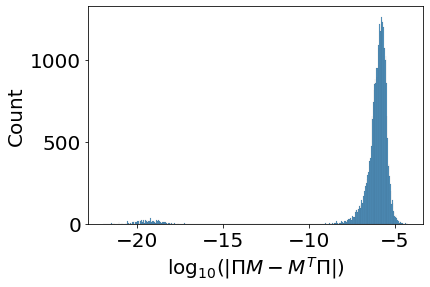

In [7]:
#ax = sns.distplot(np.log10(m1[m1!=0]), label = 'Pi*M')
ax = sns.histplot(np.log10(abs((nominator.toarray())[M.toarray()!=0])))#, label = r'$|\Pi M-M^T\Pi|$')

# ax.axvline(x = np.log10(uniform[0]), color = 'red',
#           label = 'Uniform')
ax.set(xlabel = r'$\log_{10}(|\Pi M-M^T\Pi|)$', ylabel = 'Count')
#ax.legend()
plt.show()

In [8]:
print('|Pi*M|_F =', 
      np.around(sp.linalg.norm(Pi.dot(M)),5))
print('|Pi*M-M^T*Pi|_F =', 
      np.around(sp.linalg.norm(nominator),5))
print('|Pi*M+M^T*Pi|_F =', 
      np.around(sp.linalg.norm(denominator),5))
print('|Pi*M-M^T*Pi|_F / |Pi*M+M^T*Pi|_F =', 
      np.around(sp.linalg.norm(nominator)/sp.linalg.norm(denominator),5))

|Pi*M|_F = 0.01486
|Pi*M-M^T*Pi|_F = 0.00049
|Pi*M+M^T*Pi|_F = 0.02972
|Pi*M-M^T*Pi|_F / |Pi*M+M^T*Pi|_F = 0.01655


In [9]:
# M fulfills approximately the detailed balance condition
np.around(0.00049/0.01486,3)

0.033

80th Quantile PDB: 0.26592607541122554
80th Quantile PRA: 0.33929800412938754


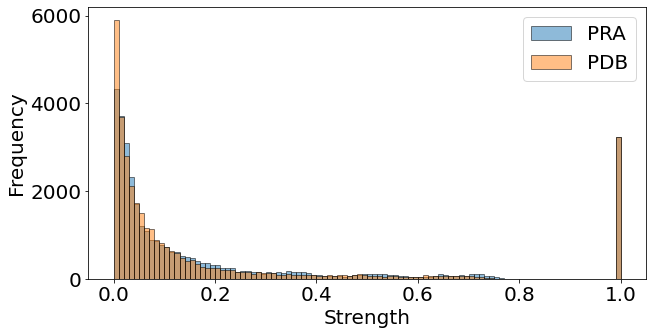

In [10]:
# Compute pairwise detailed balance
PDB = ((abs(nominator.toarray())/denominator.toarray())[M.toarray()!=0])
print("80th Quantile PDB:", np.quantile(PDB,0.80))

# Compute absolute errors, i.e. pairwise relative asymmetry
B = B_LSCC.toarray()
PRA = (abs(B- B.transpose())/(B + B.transpose()))[B>0]
print("80th Quantile PRA:", np.quantile(PRA,0.80))

# Plot histogram for pairwise relative asymmetry
fig, ax = plt.subplots(1,figsize =(10,5))
ax.hist(PRA,100,alpha=0.5, edgecolor='black',label='PRA')

# Plot histogram for pairwise detailed balance
ax.hist(PDB,100,alpha=0.5, edgecolor='black',label='PDB')
ax.set(xlabel = 'Strength',ylabel='Frequency')#,yscale='log')
ax.legend()

plt.show()

fig.savefig(root_figure+'PRA_PDB.pdf', dpi=fig.dpi,bbox_inches='tight')

In [11]:
# the one-way connections are exactly the ones that have PDB=1
sum((PDB == 1) * (PRA == 1))

3226

In [12]:
# 25% of the tiles have PDB>=0.18
np.around(np.quantile(PDB,0.75),2)

0.18

In [13]:
# 25% of the tiles have PRA>=0.23
np.around(np.quantile(PRA,0.75),2)

0.23

### Corellations of $\pi$ with other quantities

In [14]:
self_loops = np.diag(A_LSCC_array)

In [15]:
# stationary distribution is highly correlated with out-degrees
d_out = np.asarray(np.sum(B_LSCC_array,axis=1)).flatten()
print("R2 score of pi and d_out: ", R2_score(pi, d_out))
print("R2 score of pi and A_ii: ", R2_score(pi, self_loops))
print("R2 score of d_out and A_ii: ", R2_score(d_out, self_loops))

R2 score of pi and d_out:  0.9681388048640518
R2 score of pi and A_ii:  0.8328598510563936
R2 score of d_out and A_ii:  0.7651712858042974


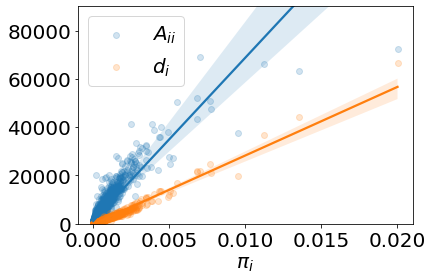

In [16]:
fig, ax = plt.subplots(1)
sns.regplot(pi,self_loops, ax=ax,label=r'$A_{ii}$',scatter_kws={'alpha' : 0.2})
sns.regplot(pi,d_out, ax=ax,label=r'$d_i$',scatter_kws={'alpha' : 0.2})
ax.set(xlabel=r'$\pi_i$', ylim = (0,90000))#,yscale='log')
ax.legend()
fig.savefig(root_figure+'Pi_correlations.pdf', dpi=fig.dpi,bbox_inches='tight')
#plt.show()

## Visualisation of baseline network

In [17]:
import mercantile
from shapely.geometry import shape
from shapely.geometry import Point
import geopandas as gpd

In [18]:
# Create GeoDataFrame for LSCC nodes
quadkeys = lscc_nodes
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf_lscc = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf_lscc = gdf_lscc.to_crs('EPSG:4326')#"EPSG:3395")

# Import NUTS shape files
root = '/home/tc/OneDrive/MSc Applied Mathematics/Research Project/Data/'
root_map = root+'GBR'+'/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs('EPSG:4326')#"EPSG:3395")

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

In [19]:
uk_cities = pd.read_csv(path+"/data/geo_shapefiles/uk_cities.csv")
uk_cities = uk_cities.astype({'lat':'float','lng':'float'})
uk_cities = uk_cities[:21]
uk_cities.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,London,51.5072,-0.1275,United Kingdom,GB,"London, City of",primary,10979000,8825001
1,Birmingham,52.4800,-1.9025,United Kingdom,GB,Birmingham,NaN,2897303,1137100
2,Manchester,53.4794,-2.2453,United Kingdom,GB,Manchester,NaN,2705000,547627
3,Leeds,53.7997,-1.5492,United Kingdom,GB,Leeds,NaN,1901934,789194
4,Newcastle,55.0077,-1.6578,United Kingdom,GB,Newcastle upon Tyne,NaN,1650000,879996


In [20]:
geometry = [Point(xy) for xy in zip(uk_cities['lng'],uk_cities['lat'])]
crs = {'init' : 'EPSG:4326'}
uk_cities_gpd = gpd.GeoDataFrame(uk_cities,crs=crs,geometry=geometry)

In [21]:
x_coord = gdf_lscc.centroid.map(lambda p: p.x)
y_coord = gdf_lscc.centroid.map(lambda p: p.y)
pos = {i : [x_coord[i],y_coord[i]] for i in range(lscc.number_of_nodes())}

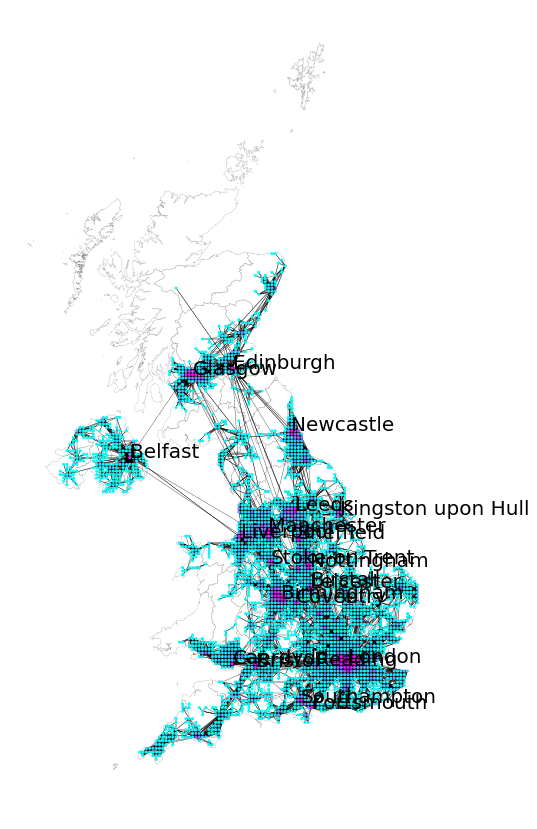

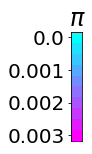

In [22]:
# Create subplot and draw graph
fig, ax = plt.subplots(1,figsize =(20,15))
#gdf_NUTS3.boundary.plot(linewidth=0.2, ax=ax, color = 'grey')
gdf_NUTS3.boundary.plot(linewidth=0.2, ax=ax, color = 'grey',zorder=1)
nx.draw(remove_self_loops(lscc), ax=ax,pos=pos,node_size=4, width = 0.3, arrows = False, 
       node_color=pi,cmap = 'cool',vmax = np.percentile(pi,99))
for x, y, label in zip(uk_cities_gpd.geometry.x, uk_cities_gpd.geometry.y, uk_cities_gpd.city):
    ax.annotate(label, xy=(x, y),zorder=12, )


fig.savefig(root_figure+'base_network_geo_pi_cities.pdf', dpi=fig.dpi,bbox_inches='tight')

plt.show()

fig, ax = plt.subplots(1,figsize =(2,2))

range_pi = np.asarray([100,4000,9000,13000,17000,21000,25000,30000,340000,38000])

ax.imshow(np.linspace(np.min(pi),np.percentile(pi,99),10).reshape(10,1),
           cmap='cool')
ax.set(xticks=[],yticks = np.arange(0,10,3),
        yticklabels=np.around(np.linspace(np.min(pi),np.percentile(pi,99),10),4)[np.arange(0,10,3)],
        title=r'$\pi$')
plt.show()


## Markov Stability (MS) analysis

We perform MS analyis on a server using the python script `src/ms_analysis.py`

### Scale selection

In [23]:
# Load data (deserialize)
with open(root_results+"MS_results.pkl", 'rb') as handle:
    all_results = pickle.load(handle)

In [24]:
# Get times
times = all_results['times']
min_time = all_results['run_params']['min_time']
max_time = all_results['run_params']['max_time']
n_time = all_results['run_params']['n_time']
log_times = np.linspace(min_time,max_time,n_time)

# Get information about communities
community_id = np.asarray(all_results['community_id'])
n_communities  = np.asarray(all_results['number_of_communities'])
n_times = len(n_communities)

In [ ]:
from pygenstability import plotting
from pygenstability.optimal_scales import identify_optimal_scales

In [ ]:
kernel_size = 10
window_size = 20
max_nvi = 1
basin_radius = 3

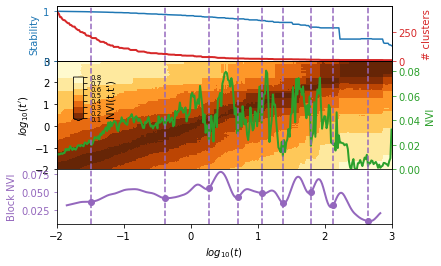

In [ ]:
# select optimal scales with nvi
identify_optimal_scales(all_results,kernel_size=10,window_size=20,basin_radius=3)

# plot summary of ms
plotting.plot_scan(all_results)
plt.show()

In [25]:
robust_scales = all_results["selected_partitions"]
block_nvi = all_results["block_detection_curve"]

### Summary plot

We modify the summary plot of MS analysis slightly to show the Block NVI on top of NVI(t,t').

In [26]:
import matplotlib.gridspec as gridspec

In [27]:
# The following code for plotting the results of Markov Stability analysis
# originates from the PyGenStability package and is only slightly modified

def plot_scan_plt(all_results, robust_scales, block_detection_curve, time_axis=True):
    """Plot results of pygenstability with matplotlib."""
    plt.figure(figsize=(10,12))
    gs = gridspec.GridSpec(3, 2, height_ratios=[0.3, 1.0,0.5], width_ratios=[1,0.1])
    gs.update(hspace=0)
    gs.update(wspace=0.1)

    ax0 = plt.subplot(gs[0, 0])
    plot_number_comm(all_results, ax=ax0, time_axis=time_axis)
    ax0.set_xticks([])

    ax2 = plt.subplot(gs[1, 0])
    im = plot_ttprime(all_results, ax=ax2, time_axis=time_axis)
    ax2.set_xticks([])
    
    
    ax3 = ax2.twinx()
    plot_scale_selection(all_results, robust_scales, block_detection_curve, ax=ax3, time_axis=time_axis)
    ax2.yaxis.tick_right()
    ax3.yaxis.tick_left()


    ax4 = plt.subplot(gs[1, 1])
    ax4.axis('off')
    plt.colorbar(im,shrink = 10, label = "NVI(s,s')")

    ax3.set_xticks([])
    ax4.set_xticks([])
    ax5 = plt.subplot(gs[2,0])
    plot_variation_information(all_results, ax=ax5, time_axis=time_axis)
    
    
    # Mark relevent times
    for i in robust_scales:
        ax3.axvline(x = log_times[i], ls="--", color = 'red',zorder=10)
        ax5.axvline(x = log_times[i], ls="--", color = 'red',zorder=10)
        
        
    return ax0, ax3, ax5


def _get_times(all_results, time_axis=True):
    """Get the time vector."""
    if not time_axis:
        return np.arange(len(all_results["times"]))
    if all_results["run_params"]["log_time"]:
        return np.log10(all_results["times"])
    return all_results["times"]


def plot_number_comm(all_results, ax, time_axis=True):
    """Plot number of communities."""
    times = _get_times(all_results, time_axis)

    ax.plot(
        times, all_results["number_of_communities"], "-", c="C0", label="size", lw=2.0
    )
    ax.set_ylabel("#comm.", color="C0")
    ax.tick_params("y", colors="C0")
    ax.axis([times[0], times[-1],  np.min(all_results["number_of_communities"]) * 0.9, 
             np.max(all_results["number_of_communities"]) * 1.1])
    
    ax.set(yscale='log')

    for i in robust_scales:
        ymax = 1 
        ax.axvline(x = log_times[i], ymax = ymax , ls="--", color = 'red',zorder=10)


def plot_ttprime(all_results, ax, time_axis):
    """Plot ttprime."""
    times = _get_times(all_results, time_axis)

    im = ax.contourf(times, times, all_results["ttprime"], cmap="YlOrBr_r")
    ax.set_ylabel(r"$s^\prime$")
    
    ax.axis([times[0], times[-1], times[0], times[-1]])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    #ax.set(sitle='Selection of most relevant scales in Markov Stability analysis')
    
    return im


def plot_variation_information(all_results, ax, time_axis=True):
    """Plot variation information."""
    times = _get_times(all_results, time_axis=time_axis)
    ax.plot(times, all_results["variation_information"], "-", lw=2.0, c="C2", label="VI")

    ax.yaxis.tick_left()
    ax.tick_params("y", colors="C2")
    ax.set_ylabel("NVI(s)", color="C2")
    
    ax.yaxis.set_label_position("left")
    #ax.axhline(1, ls="--", lw=1.0, c="C2")
    ax.axis([times[0], times[-1], np.min(all_results["variation_information"]) * 0.9, 
             np.max(all_results["variation_information"]) * 1.1])
    ax.set_xlabel(r"$s$")


def plot_stability(all_results, ax, time_axis=True):
    """Plot stability."""
    times = _get_times(all_results, time_axis=time_axis)
    ax.plot(times, all_results["stability"], "-", label=r"$Q$", c="C0")

    ax.yaxis.tick_right()
    ax.tick_params("y", colors="C0")
    ax.set_ylabel("Stability", color="C0")
    ax.yaxis.set_label_position("right")
    ax.set_xlabel(r"$log_{10}(s)$")
    ax.axis([times[0], times[-1],  np.min(all_results["stability"]) * 0.9, 
             np.max(all_results["stability"]) * 1.1])

def plot_scale_selection(all_results, robust_scales, block_detection_curve, ax, time_axis=True):
    
    # plot
    color = 'black'
    times = _get_times(all_results, time_axis=time_axis)
    for i in robust_scales:
            ax.axvline(x=times[i], ls="--", color = 'red',alpha=1)
    #ax.axhline(y=max_nvi_tt, ls = ':', color = 'black')
    ax.plot(times, block_detection_curve, color=color, alpha=1)
    ax.set(xlabel=r"$log_{10}(s)$", ylabel = 'NVI')

    ax.tick_params("y", colors=color)
    ax.set_ylabel(r"Block NVI", color=color)
    ax.yaxis.set_label_position("left")
    # ax.set_xlabel(r"$log_{10}(s)$")
    ax.set(xlim=(times[0], times[-1])) 

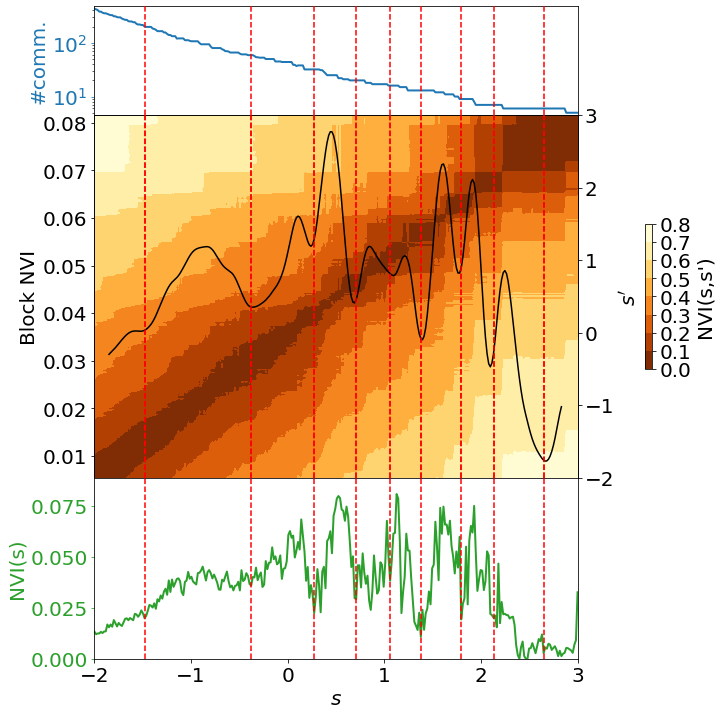

In [28]:
ax0, ax3, ax5 = plot_scan_plt(all_results,robust_scales, block_nvi)
fig = ax3.get_figure()
#plt.show()
fig.savefig(root_figure+'MS_scan.pdf', dpi=fig.dpi,bbox_inches='tight')

### Statistics of MS partitions

In [29]:
community_id_ranked = community_id.copy()

for time in range(n_times):
    # Compute sizes of each community
    labels_graph_counts = np.histogram(community_id[time],bins=np.arange(0,n_communities[time]+1)) [0]
    # Get class indices sorted according to size
    community_ranked = np.argsort(-labels_graph_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {community_ranked[k] : k for k in range(0,n_communities[time])}
    # Apply permutation to labels
    labels_community = community_id[time].copy()
    for i in range (0,len(labels_community)):
        labels_community[i] = rank[labels_community[i]]
    
    community_id_ranked[time] = labels_community

In [30]:
max_c = []
Q1_c = []
Q2_c = []
Q3_c = []
min_c = []

for i in robust_scales:

    partition = community_id_ranked[i]
    labels_graph_counts = np.histogram(partition,bins=np.arange(0,n_communities[i]+1)) [0]
    max_c.append(int(np.max(labels_graph_counts)))
    Q1_c.append(int(np.percentile(labels_graph_counts, q =25)))
    Q2_c.append(int(np.percentile(labels_graph_counts, q =50)))
    Q3_c.append(int(np.percentile(labels_graph_counts, q =75)))
    min_c.append(int(np.min(labels_graph_counts)))
    
community_stats = pd.DataFrame({'Markov times' : np.around(log_times[robust_scales],2),
                                'n_communities' : n_communities[robust_scales], 'min_size' : min_c,
                                'Q1':Q1_c, 'Q2' : Q2_c, 'Q3' : Q3_c, 'max_size' : max_c})

In [31]:
community_stats

,Markov times,n_communities,min_size,Q1,Q2,Q3,max_size
0,-1.48,201,1,7,13,22,59
1,-0.38,59,4,34,49,67,169
2,0.27,32,10,67,87,116,246
3,0.71,20,42,98,133,201,348
4,1.06,16,9,107,168,274,468
5,1.38,13,9,126,263,313,590
6,1.80,9,186,246,274,376,816
7,2.13,7,190,260,319,560,975
8,2.65,6,190,253,365,835,997


### Visualise partitions

In [32]:
community_set = []
node_keys = lscc_nodes

for time in range(n_time):

    labels = community_id_ranked[time]
    k = np.max(labels)
    partition = []
    for i in range(k+1):
        c = np.argwhere(labels == i).flatten()
        c_set = set(node_keys[j] for j in c)
        partition.append(c_set)
    community_set.append(partition)

community_set = np.asarray(community_set)

# get relevant partitions
relevant_times = np.asarray([31, 97, 136, 162, 183, 202, 227, 247, 278])
c = community_set[relevant_times]

In [33]:

import geopandas as gpd
from geopandas import GeoDataFrame
import mercantile
from shapely.geometry import shape

import plotly.graph_objects as go

In [34]:
# Import NUTS shape files
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# remove Scotish islands
map_gdf=map_gdf[~map_gdf['nuts318cd'].isin(['UKM65', 'UKM66'])]
map_gdf.reset_index(drop=True,inplace=True)

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

gdf_NUTS3['DUMMY'] = 1
gdf_bndr = gdf_NUTS3.dissolve(by = 'DUMMY')

# Get NUTS2
gdf_NUTS2 = gdf_NUTS3.copy()
gdf_NUTS2['nuts'] = [gdf_NUTS2['nuts'][i][:4] for i in range((len(gdf_NUTS3)))]
gdf_NUTS2 = gdf_NUTS2.dissolve(by='nuts')

# Get NUTS1
gdf_NUTS1 = gdf_NUTS3.copy()
gdf_NUTS1['nuts'] = [gdf_NUTS1['nuts'][i][:3] for i in range(len(gdf_NUTS3))]
gdf_NUTS1 = gdf_NUTS1.dissolve(by='nuts')

1
201


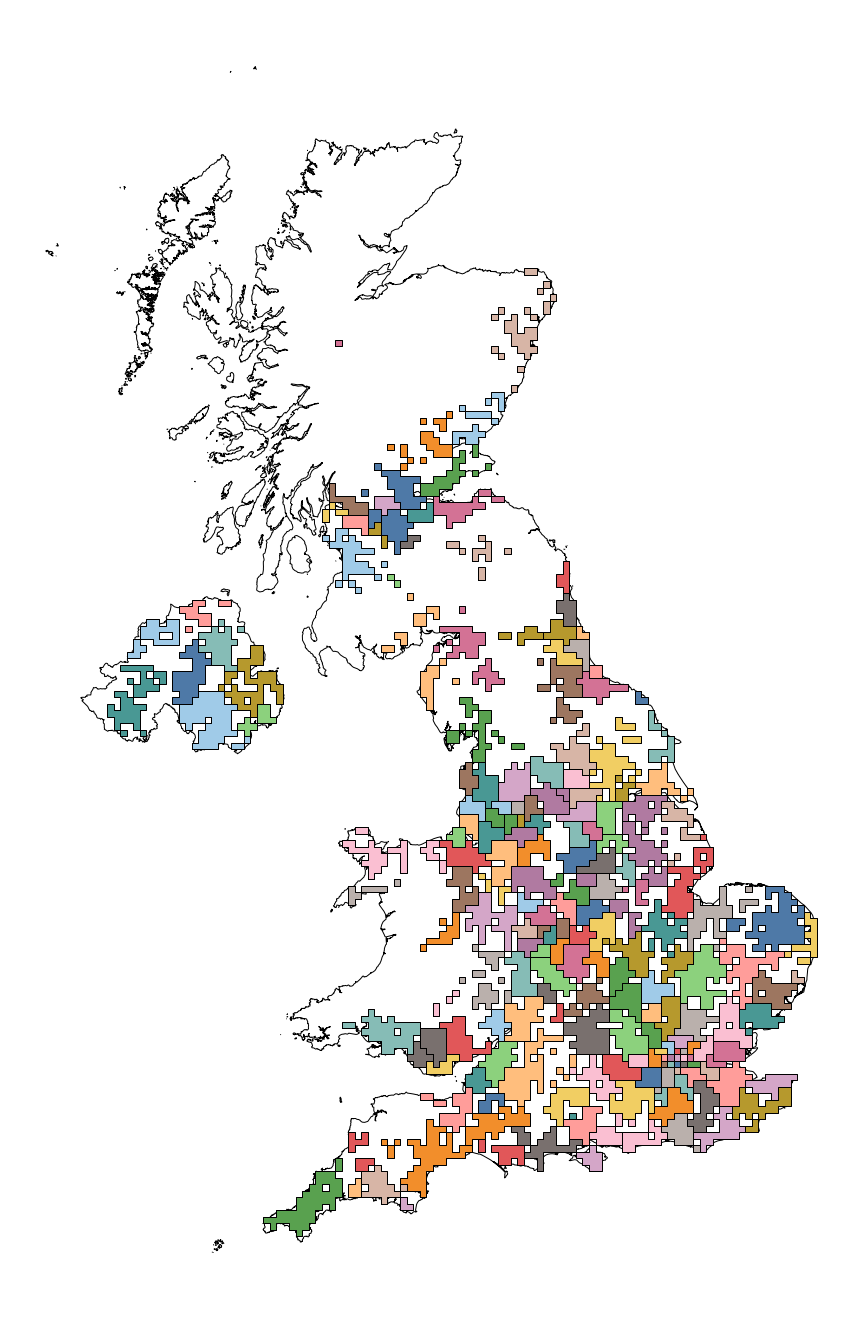

2
59


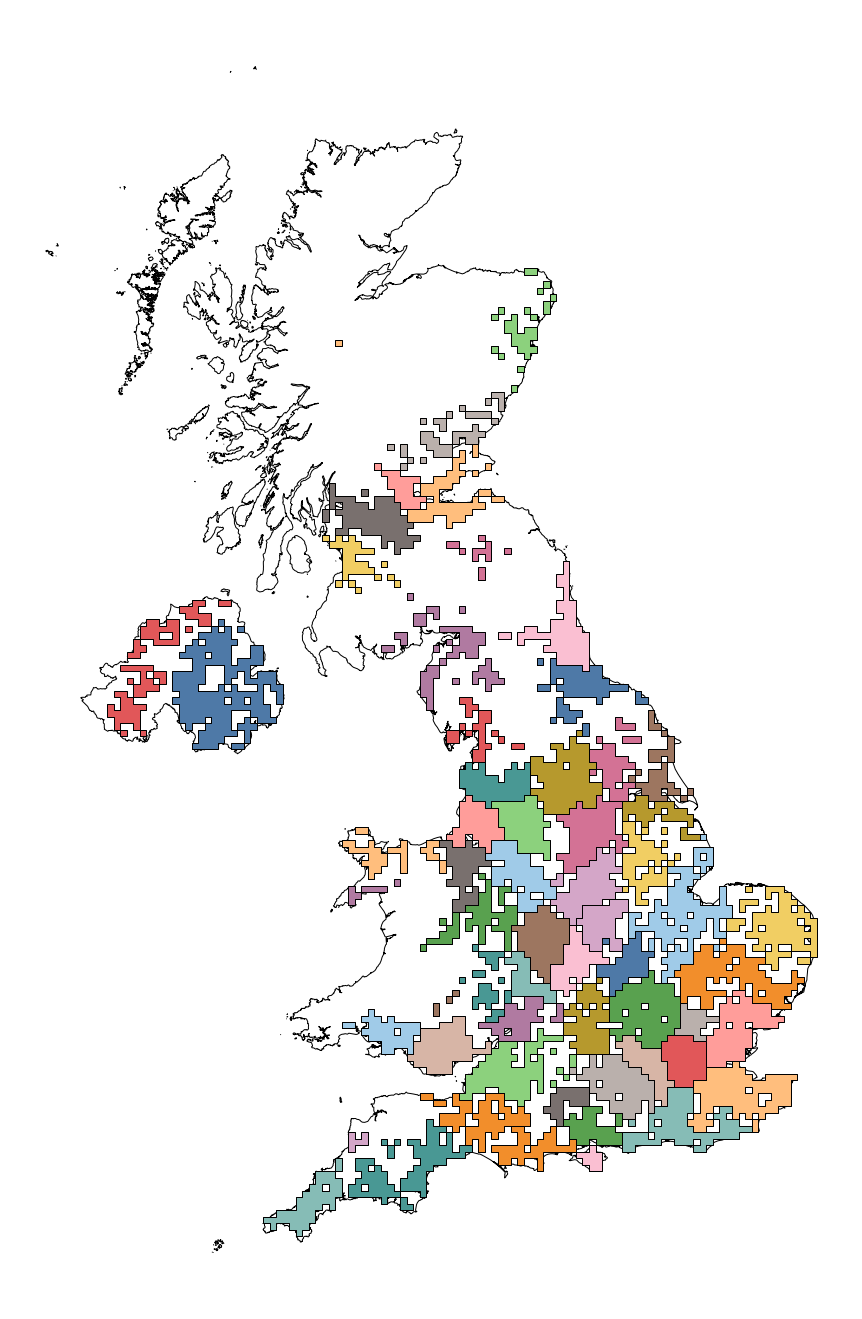

3
32


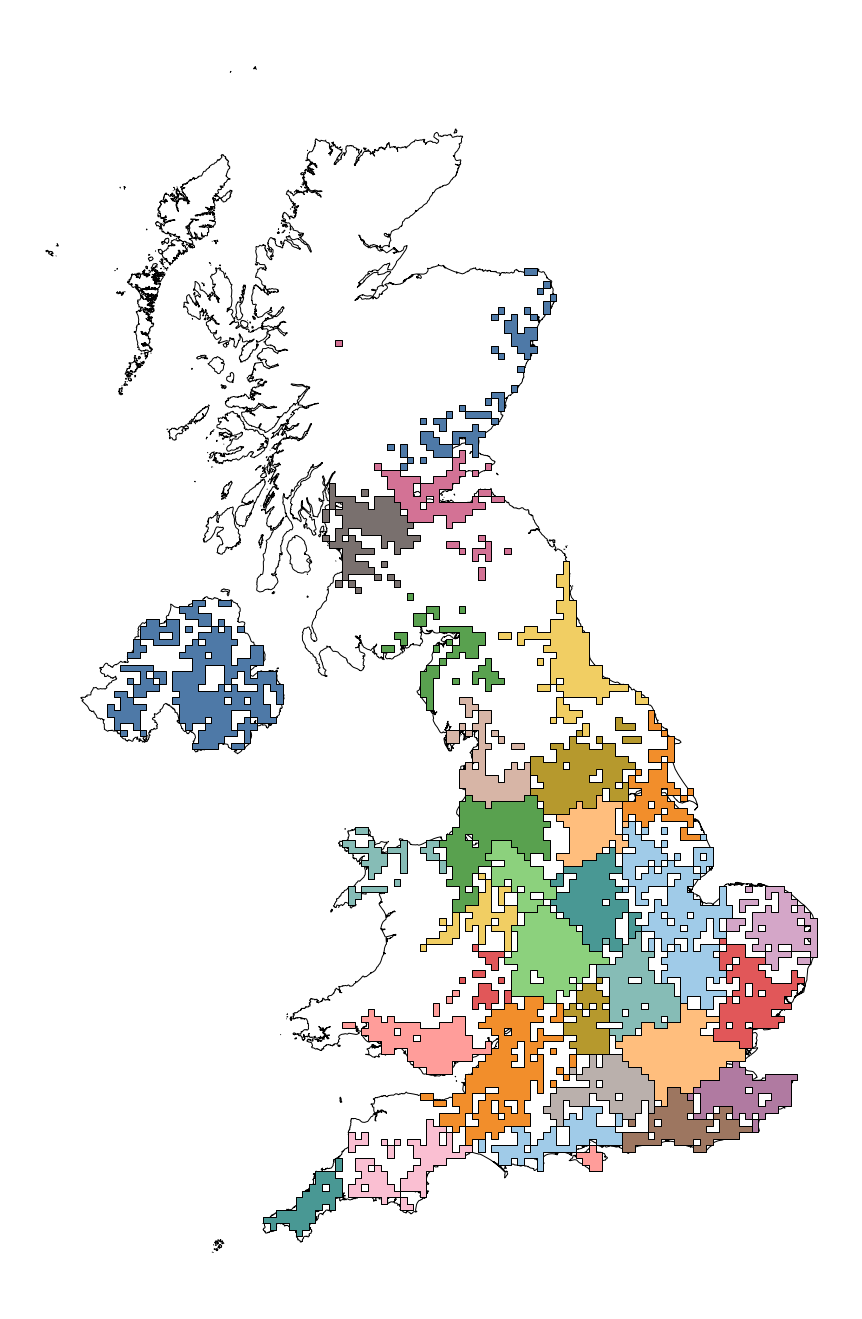

4
20


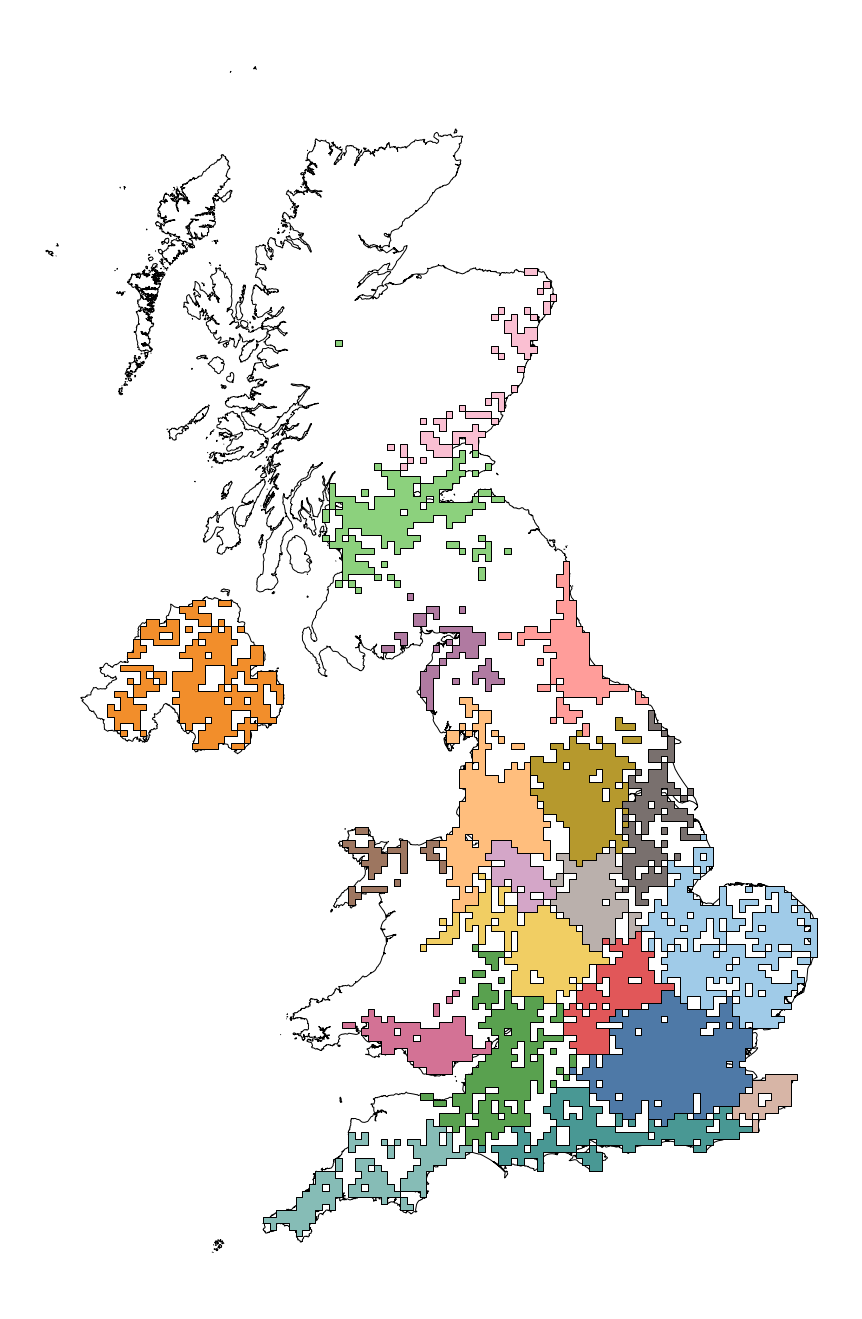

5
16


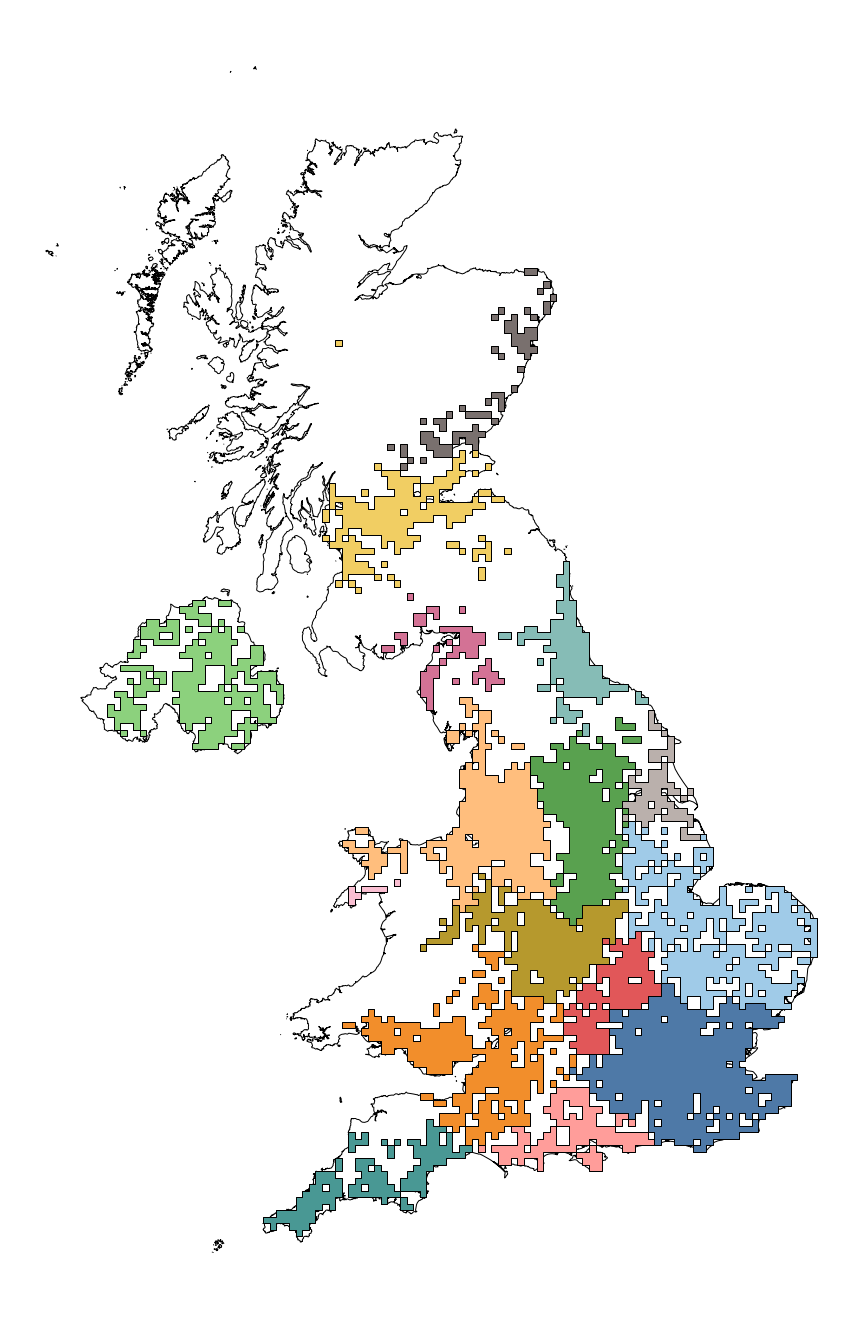

6
13


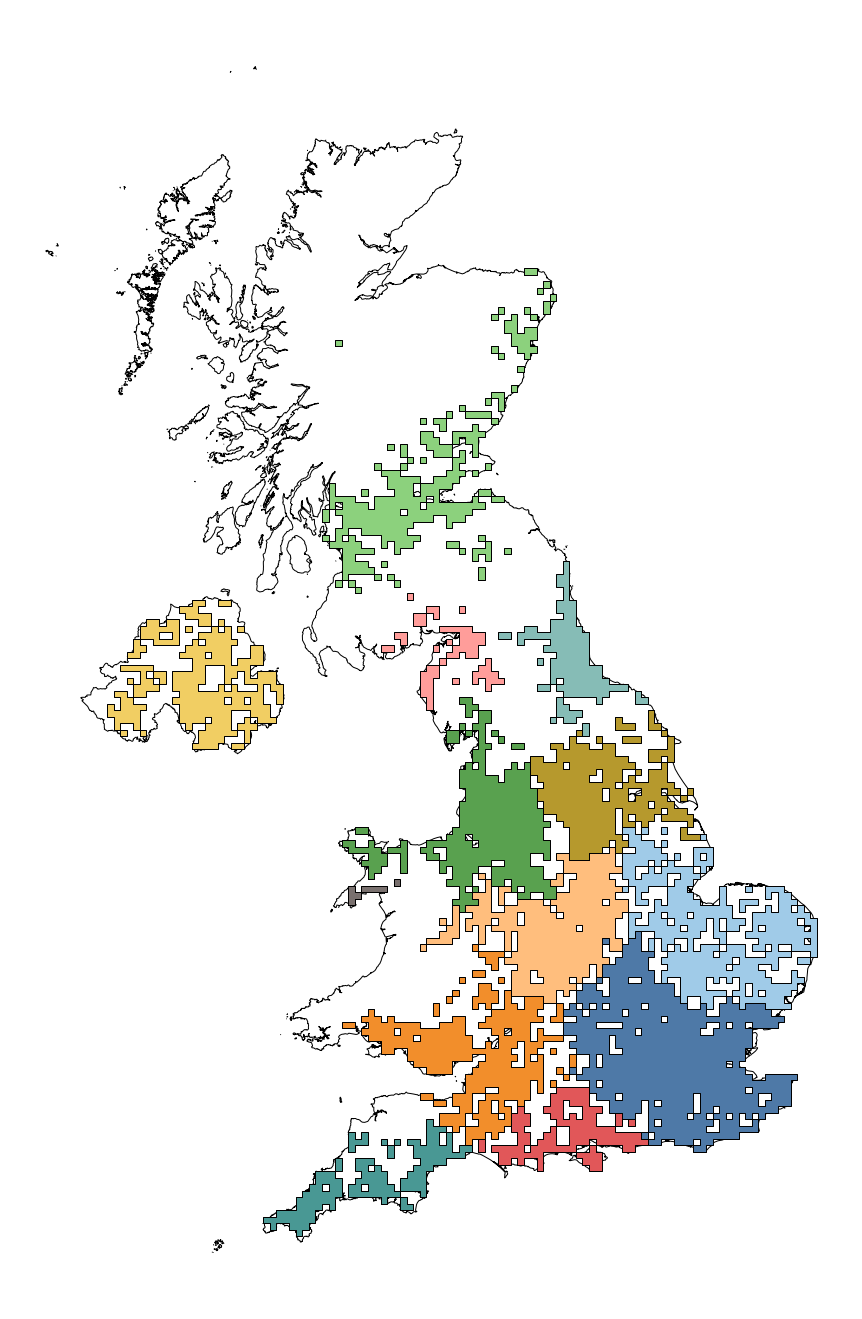

7
9


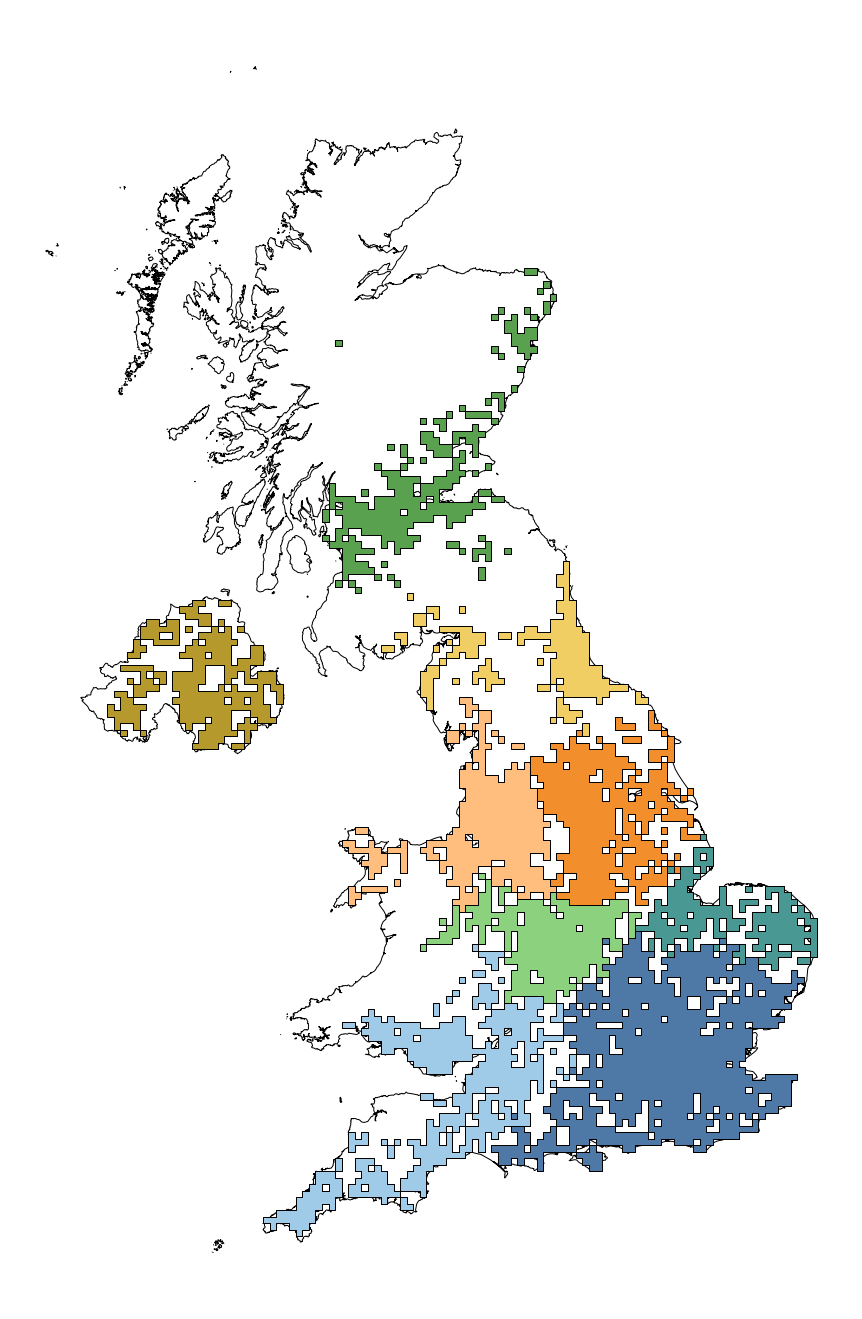

8
7


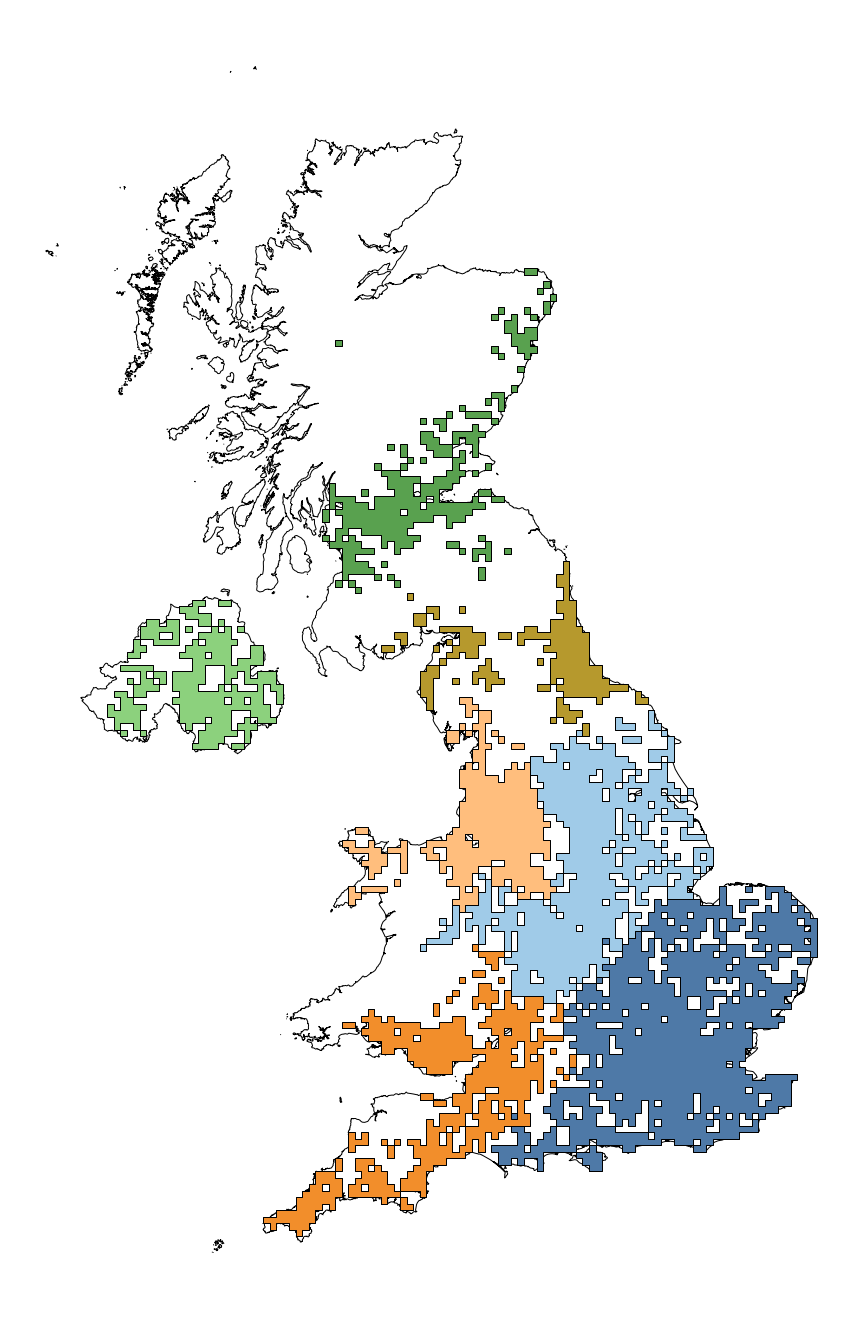

9
6


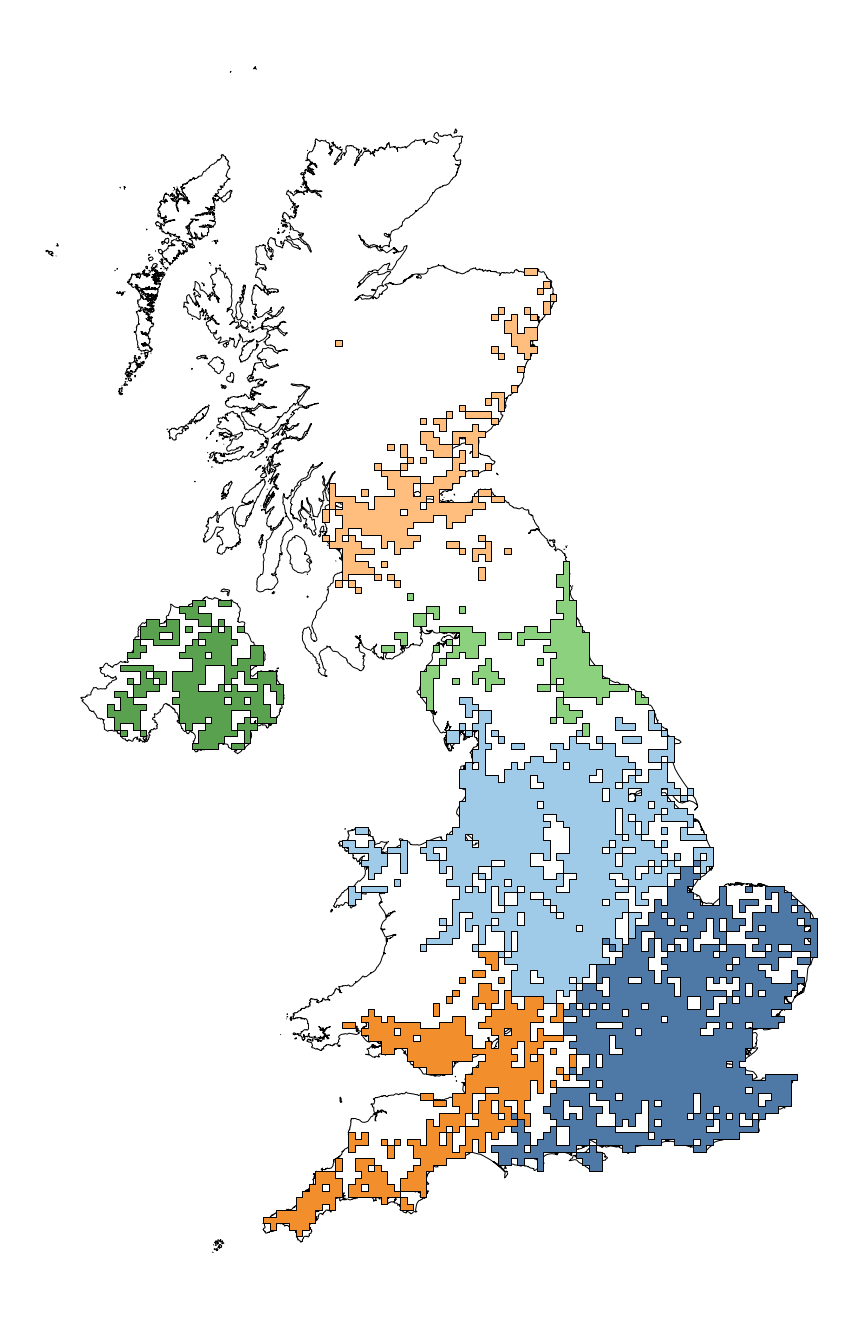

In [35]:
for i in range(0,len(c)):
    print(i+1)
    comms_list = c[i]
    tile_list = []

    for j in comms_list:
        tile_list = tile_list+list(j)

    #print(len(tile_list))

    polys = []

    # Iterate over all quadkeys to create corresponding polygons
    for quadkey in tile_list:
        tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
        polys.append(tile.get('geometry'))
    geom = [shape(i) for i in polys]
    gdf_lscc = gpd.GeoDataFrame({'geometry':geom, 'quadkey':tile_list}, crs = "EPSG:4326")
    gdf_lscc = gdf_lscc.to_crs("EPSG:3395")

    gdf_lscc['COMM'] = None

    print(len(comms_list))

    for j in range(0,len(comms_list)):

        gdf_lscc.loc[gdf_lscc['quadkey'].isin(comms_list[j]), 'COMM'] = j

    gdf_lscc_diss = gdf_lscc.dissolve(by = 'COMM')

    tab_20 = ['#4E79A7', '#A0CBE8', '#F28E2B', '#FFBE7D', '#59A14F',
             '#8CD17D', '#B6992D', '#F1CE63', '#499894', '#86BCB6',
             '#E15759', '#FF9D9A', '#79706E', '#BAB0AC', '#D37295',
             '#FABFD2', '#B07AA1', '#D4A6C8', '#9D7660', '#D7B5A6']

    while len(tab_20) < np.max(gdf_lscc['COMM']):
        tab_20 = tab_20+tab_20

    df_color = pd.DataFrame(tab_20)
    df_color.columns = ['COLOR']
    df_color = df_color.reset_index()

    df_color.columns = ['COMM', 'COLOR']
    gdf_lscc = pd.merge(gdf_lscc,df_color,how='left', on = 'COMM')
    gdf_lscc_diss = pd.merge(gdf_lscc_diss,df_color,how='left', on = 'COMM')

    f, ax = plt.subplots(1, figsize=(40, 24))
    gdf_bndr.plot(linewidth=1, ax=ax, edgecolor= 'black', facecolor = 'white')
    gdf_lscc_diss.plot(linewidth=1, ax=ax, edgecolor= 'black', facecolor = gdf_lscc_diss['COLOR'])
    ax.set_axis_off()
    plt.savefig(root_figure+'CLUSTER_PLOT_'+str(i+1)+'.pdf', bbox_inches = 'tight')
    plt.show()

### Quasi-hierachy

#### a) Sankey diagram

In [36]:
# The following code for plotting the results of Markov Stability analysis
# originates from the PyGenStability package and is only slightly modified

import plotly.graph_objects as go

time_index=robust_scales

sources = []
targets = []
values = []
shift = 0


all_results['community_id_reduced']  = [community_id_ranked[i] for i in time_index] 


#for i in range(len(all_results['community_id']) - 1):
for i in range(len(all_results['community_id_reduced']) - 1):
    community_source = np.array(all_results['community_id_reduced'][i])
    community_target = np.array(all_results['community_id_reduced'][i + 1])
    source_ids = set(community_source)
    target_ids = set(community_target)
    for source in source_ids:
        for target in target_ids:
            value = sum(community_target[community_source == source] == target)
            if value > 0:
                values.append(value)
                sources.append(source + shift)
                targets.append(target + len(source_ids) + shift)
    shift += len(source_ids)

layout = go.Layout(autosize=True)
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=1,
                thickness=1,
                line=dict(color="black", width=0.0)
            ),

            link=dict(source=sources, target=targets, value=values),
        )
    ],
    layout=layout,
)

fig.show()
fig.write_image(root_figure+"Sankey_Optimal_Partitions.pdf", format='pdf')

#### b) conditional entropy

see Lambiotte et al. 2009: belongs to the interval [0, 1], but is now an asymmetric quantity that vanishes only if each community of Pt is the union of communities of Pt

In [37]:
def entropy(labels):
    """Calculates the entropy for a labeling.
    Parameters
    ----------
    labels : int array, shape = [n_samples]
        The labels
    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - log(pi_sum)))

def variation_of_information(x,y, normalised = True):
    Ex = entropy(x)
    Ey = entropy(y)
    I = metrics.mutual_info_score(x,y)
    
    if normalised:
        return  (Ex + Ey - 2*I) / (Ex + Ey - I)
    else: 
        return Ex + Ey - 2*I

def normalised_conditional_entropy(x,y):
    """
    H(X|Y) = H(X) - I(X,Y) and we normalise with log(N)
    """
    
    N = len(x)
    Ex = entropy(x)
    I = metrics.mutual_info_score(x,y)

    return (Ex - I) / np.log(N)

In [38]:
NCE_lower = np.zeros((n_time,n_time))

for t in range(n_time):
    for t_prime in range(t):
        NCE_lower[t,t_prime] = normalised_conditional_entropy(community_id_ranked[t],community_id_ranked[t_prime])

In [39]:
import matplotlib.patches as mpatches

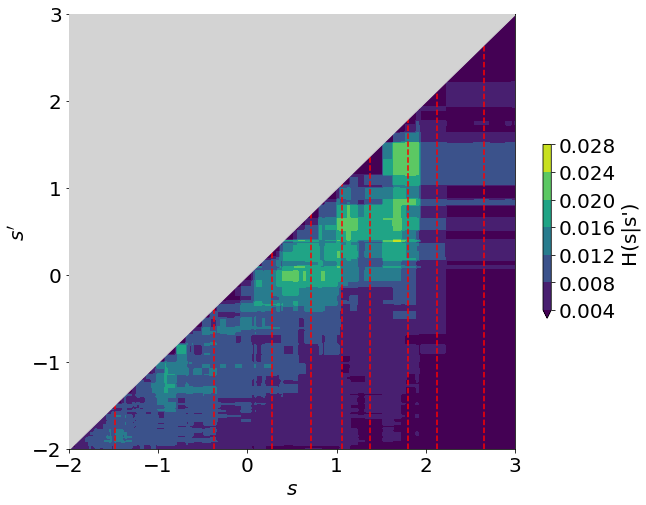

In [40]:
fig, ax = plt.subplots(1,figsize =(10,8))
times = _get_times(all_results, True)
im = ax.contourf(times, times, NCE_lower.transpose(),extend = 'min')
ax.set_ylabel(r"$s^\prime$")
ax.set_xlabel(r"$s$")
ax.axis([times[0], times[-1], times[0], times[-1]])

for i in robust_scales:
    ax.axvline(x = log_times[i], ls="--", color = 'red',zorder=10)

# plot lower diag patch
tmin = times[0]
tmax = times[-1]

ax.add_patch(
    mpatches.Polygon(
        [[tmin, tmin], [tmin, tmax], [tmax, tmax]], fill=True, zorder=20, color="lightgrey"
    )
)

plt.colorbar(im,shrink = 0.4, label = "H(s|s')")

fig.savefig(root_figure+'NCE.pdf', dpi=fig.dpi,bbox_inches='tight')